# Demo: Vision Language Models for Historical Data Extraction

This notebook demonstrates how to use Vision Language Models (VLMs) to extract structured data directly from scanned historical documents. We'll work with handwritten Dutch tax records from 1899, showing how a single API call can replace traditional OCR + post-processing pipelines.

See the companion research report for detailed evaluation across multiple models and configurations.

## 1. Setup

First, let's install the required packages and set up authentication.

In [29]:
# Install required packages
!pip install google-genai pillow requests -q


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [30]:
import json
import os
import requests
from pathlib import Path
from PIL import Image
from io import BytesIO

from google import genai
from google.genai import types
from google.genai.types import Content, FileData, GenerateContentConfig, Part

### API Key Setup

You'll need a Google Gemini API key. Get one for free at: https://aistudio.google.com/app/apikey

**Note:** The free API tier is limited to a few requests per day. For heavy use you'll have to set up billing. Monitor the cost well!

**For Google Colab users:** You can use Colab's secrets feature:
1. Click the key icon (🔑) in the left sidebar
2. Add a new secret named `GEMINI_API_KEY`
3. Paste your API key
4. Toggle on "Notebook access"

Then uncomment and run:
```python
from google.colab import userdata
os.environ['GEMINI_API_KEY'] = userdata.get('GEMINI_API_KEY')
```

**For local Jupyter:** Set the environment variable directly:

In [31]:
# Option 1: For Google Colab (uncomment if using Colab)
# from google.colab import userdata
# os.environ['GEMINI_API_KEY'] = userdata.get('GEMINI_API_KEY')


# Option 3: If you already have it set as an environment variable, nothing to do!

# Initialize the client
client = genai.Client(api_key=os.environ['GEMINI_API_KEY'])
print("✓ Gemini client initialized successfully!")

✓ Gemini client initialized successfully!


## 2. Data Preparation

Download the sample images and ground truth data from the GitHub repository.

In [ ]:
# GitHub repository base URL
GITHUB_BASE = "https://raw.githubusercontent.com/HIP-NL/nocr-experiments/main/data"

# Image files
IMAGE_FILES = [
    "NL-UtHUA_A376076_000033_r.jpg",
    "NL-UtHUA_A376076_000033_l.jpg",
    "NL-UtHUA_A376079_000005_r.jpg",
    "NL-UtHUA_A376079_000005_l.jpg",
]

def download_from_github(path):
    """Download a file from GitHub and return its content."""
    url = f"{GITHUB_BASE}/{path}"
    response = requests.get(url)
    response.raise_for_status()
    return response.content

print("✓ GitHub URLs configured")

✓ GitHub URLs configured


### Display Sample Data

Let's look at one of the historical tax record scans and its corresponding ground truth. Note that the image is heavily cropped to ease the task. Having consistent scans that allow this is important.

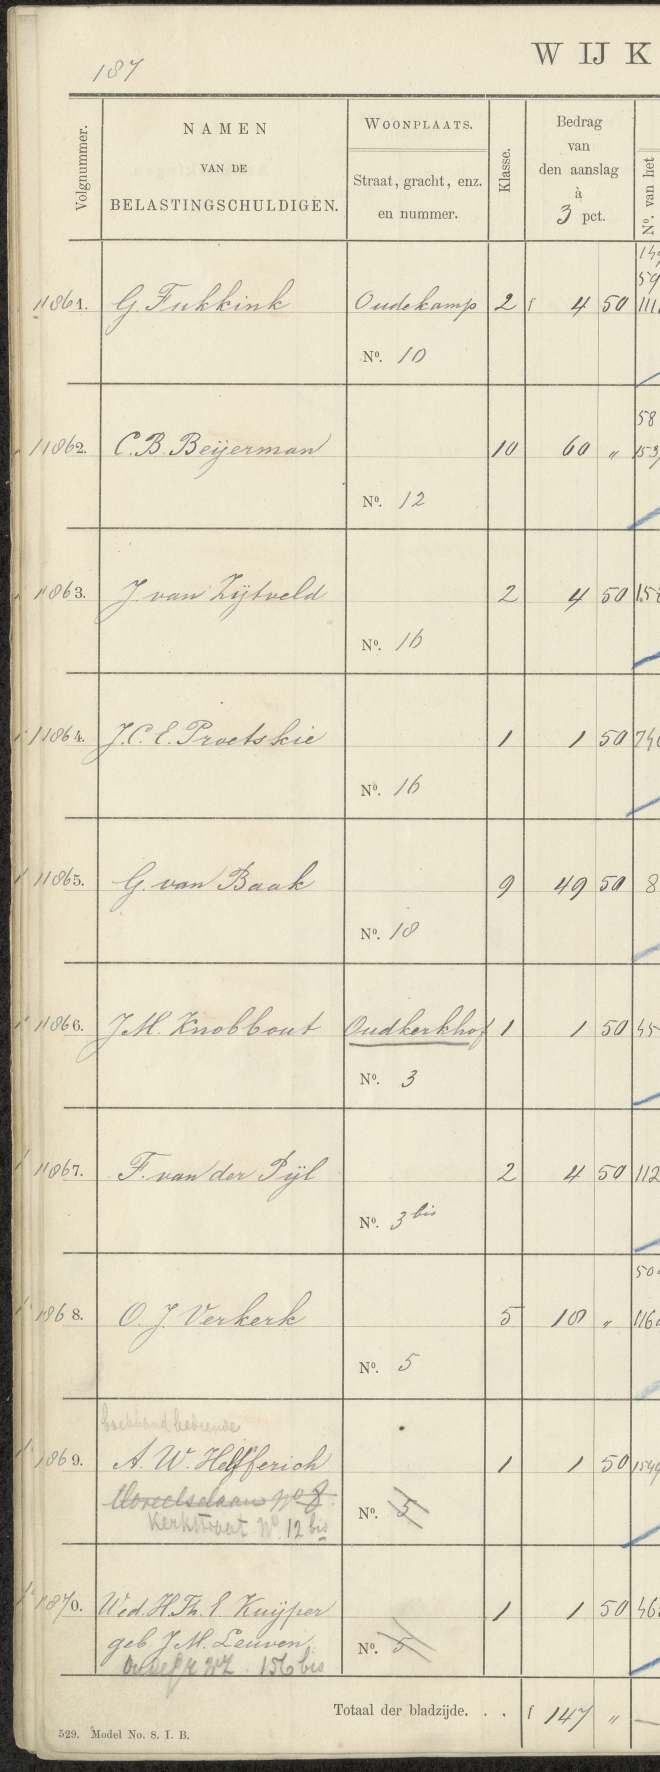

In [33]:
# Display first image
sample_image = IMAGE_FILES[0]
img_data = download_from_github(f"images/{sample_image}")
img = Image.open(BytesIO(img_data))
img.reduce(3)


In [34]:
# Load and display ground truth
gt_file = sample_image.replace('.jpg', '.json')
gt_data = download_from_github(f"ground_truth/{gt_file}")
ground_truth = json.loads(gt_data)

print(f"Ground truth for {sample_image}:")
print(json.dumps(ground_truth[:3], indent=2))  # Show first 3 entries
print(f"\n... ({len(ground_truth)} total entries)")

Ground truth for NL-UtHUA_A376076_000033_l.jpg:
[
  {
    "volgnummer": 1861,
    "title": null,
    "initials": "G.",
    "surname": "Fukkink",
    "maiden_name": null,
    "street": "Oudekamp",
    "house_number": "10",
    "class": 2,
    "tax": 4.5
  },
  {
    "volgnummer": 1862,
    "title": null,
    "initials": "C.B.",
    "surname": "Beijerman",
    "maiden_name": null,
    "street": "Oudekamp",
    "house_number": "12",
    "class": 10,
    "tax": 60.0
  },
  {
    "volgnummer": 1863,
    "title": null,
    "initials": "J.",
    "surname": "van Zijtveld",
    "maiden_name": null,
    "street": "Oudekamp",
    "house_number": "16",
    "class": 2,
    "tax": 4.5
  }
]

... (10 total entries)


## 3. Understanding the Task

Let's examine the prompt that instructs the model on what to extract and how to handle edge cases.

In [35]:
# Load and display the prompt
prompt_data = download_from_github("prompt.txt")
prompt_text = prompt_data.decode('utf-8')

print(prompt_text)

Extract the data from this scan and return it as json.

The scan contains five columns describing individuals being taxed in the Dutch city of Utrecht in 1899. Extract the following information and return it as json:
- volgnummer, the sequential number of the individual in the scan, an integer number at most four digits long. If there are more digits, the first one is probably from the previous page and should be ignored.
- title, a title such as 'Wed.', 'Dr.', 'Mej', 'jkhr', 'jkvr', 'geb', 'vert', 'p/a', 'cur'. If the scan does not contain a title, leave this empty (null).
- initials, the initials of the individual.
- surname, the surname of the individual.
- maiden name, the full maiden name of the individual, below the husband's name and indicated with 'geb' (for 'geboren'), typically provided if she is a widow.
- street, the street in Utrecht of the individual, always in the 'woonplaats' column. If a street is omitted because it is the same as the previous row fill in the missing v

## 4. Helper Functions

Let's define some utility functions we'll use throughout the notebook.

In [36]:
def load_ground_truth(image_name):
    """Load ground truth JSON for an image."""
    gt_file = image_name.replace('.jpg', '.json')
    gt_data = download_from_github(f"ground_truth/{gt_file}")
    return json.loads(gt_data)

def display_image(image_name):
    """Display an image."""
    img_data = download_from_github(f"images/{image_name}")
    img = Image.open(BytesIO(img_data))
    display(img.reduce(3))

def upload_image(image_name):
    """Upload an image from GitHub to Gemini and return a Part object."""
    img_data = download_from_github(f"images/{image_name}")
    img = Image.open(BytesIO(img_data))
    
    # Save to temporary bytes buffer to upload
    buf = BytesIO()
    img.save(buf, format='JPEG')
    buf.seek(0)
    
    file = client.files.upload(file=buf, config=dict(mime_type="image/jpeg"))
    return Part(file_data=FileData(mime_type=file.mime_type, file_uri=file.uri))

## 5. Zero-Shot Example

Let's start with a **zero-shot** approach: just the prompt and target image, no examples.

### 5.1 Setup

Zero-shot target: NL-UtHUA_A376076_000033_l.jpg


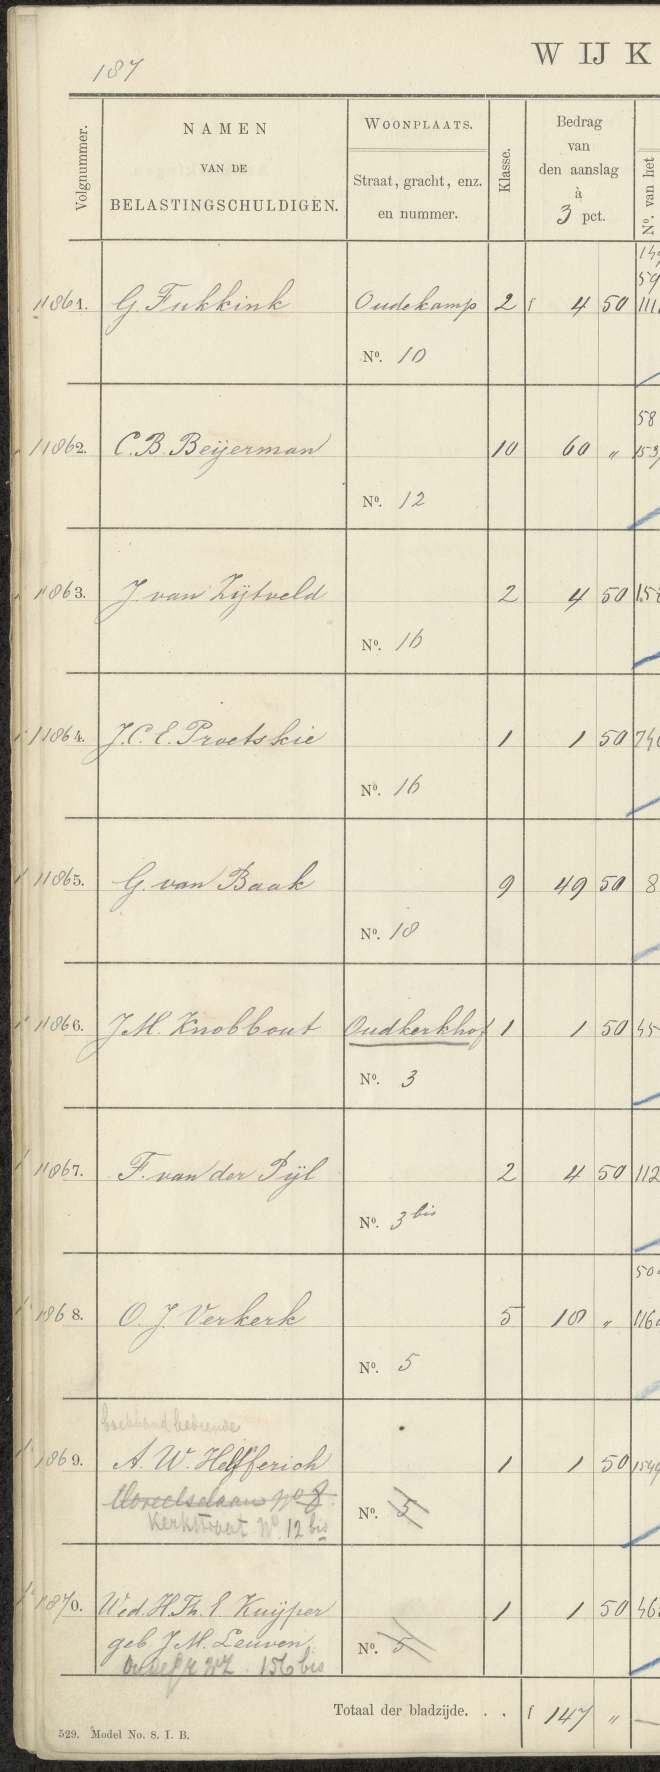

In [37]:
# Select target image for zero-shot experiment
target_image_zeroshot = IMAGE_FILES[0]  # First image

print(f"Zero-shot target: {target_image_zeroshot}")
display_image(target_image_zeroshot)

In [38]:
# Upload the target image to Gemini
print("Uploading image to Gemini...")
target_image_part_zs = upload_image(target_image_zeroshot)

# Prepare the prompt
prompt_part = Part(text=prompt_text)

print("✓ Image uploaded")

Uploading image to Gemini...
✓ Image uploaded


### 5.2 Run the Model

We'll use `gemini-2.5-flash` which offers a good balance of cost and performance.

The most cost effient option is gemini-2.0.flash (see the report), but this model will unfortunately be deprecated by google.

In [39]:
model_name = "models/gemini-2.5-flash"
# Configuration - MODIFY THESE TO EXPERIMENT!
thinking_budget = 0  # Try: 0 (no thinking) or 2000 (extended reasoning)
temperature = 0.9    # Try: 0.0 (deterministic) to 1.0 (creative)


print(f"Running {model_name} in zero-shot mode...")
print("This may take 10-30 seconds...\n")

# Configure thinking, set to None for 2.0 models
thinking_config = types.ThinkingConfig(thinking_budget=thinking_budget)

if model_name.startswith("models/gemini-2.0"):
    thinking_config = None

# Generate content
response_zeroshot = client.models.generate_content(
    model=model_name,
    config=GenerateContentConfig(
        response_mime_type="application/json",
        temperature=0.9,
        thinking_config=thinking_config,
    ),
    contents=messages_zeroshot,
)

print("✓ Model response received!")

Running models/gemini-2.5-flash in zero-shot mode...
This may take 10-30 seconds...

✓ Model response received!


### 5.3 Inspect Results

In [40]:
# Parse the response
if response_zeroshot.text:
    prediction_zeroshot = json.loads(response_zeroshot.text)
    
    print("Model Output (Zero-Shot):")
    print("=" * 80)
    print(json.dumps(prediction_zeroshot[:3], indent=2, ensure_ascii=False))
    print(f"\n... ({len(prediction_zeroshot)} total records)")
else:
    print("⚠ No response text received")
    prediction_zeroshot = None

Model Output (Zero-Shot):
[
  {
    "volgnummer": 1861,
    "title": null,
    "initials": "G.",
    "surname": "Tinkink",
    "maiden_name": null,
    "street": "Oudekamp",
    "house_number": "10",
    "class": 2,
    "tax": 4.5
  },
  {
    "volgnummer": 1862,
    "title": null,
    "initials": "C.B.",
    "surname": "Beijerman",
    "maiden_name": null,
    "street": "Oudekamp",
    "house_number": "12",
    "class": 10,
    "tax": 60.0
  },
  {
    "volgnummer": 1863,
    "title": null,
    "initials": "J.",
    "surname": "van Nijveld",
    "maiden_name": null,
    "street": "Oudekamp",
    "house_number": "16",
    "class": 2,
    "tax": 4.5
  }
]

... (10 total records)


In [41]:
# Load ground truth for comparison
gt_zeroshot = load_ground_truth(target_image_zeroshot)

print("Ground Truth:")
print("=" * 80)
print(json.dumps(gt_zeroshot[:3], indent=2, ensure_ascii=False))
print(f"\n... ({len(gt_zeroshot)} total records)")

Ground Truth:
[
  {
    "volgnummer": 1861,
    "title": null,
    "initials": "G.",
    "surname": "Fukkink",
    "maiden_name": null,
    "street": "Oudekamp",
    "house_number": "10",
    "class": 2,
    "tax": 4.5
  },
  {
    "volgnummer": 1862,
    "title": null,
    "initials": "C.B.",
    "surname": "Beijerman",
    "maiden_name": null,
    "street": "Oudekamp",
    "house_number": "12",
    "class": 10,
    "tax": 60.0
  },
  {
    "volgnummer": 1863,
    "title": null,
    "initials": "J.",
    "surname": "van Zijtveld",
    "maiden_name": null,
    "street": "Oudekamp",
    "house_number": "16",
    "class": 2,
    "tax": 4.5
  }
]

... (10 total records)


In [42]:
# Compare results
if prediction_zeroshot:
    compare_results(prediction_zeroshot, gt_zeroshot, target_image_zeroshot)


Comparison for NL-UtHUA_A376076_000033_l.jpg
Field-level accuracy: 78/90 (86.7%)
Records compared: 10/10

First record with errors (record #1):
  • surname:
      Predicted:    Tinkink
      Ground truth: Fukkink


In [44]:
# Display token usage and cost
response_zeroshot.usage_metadata

GenerateContentResponseUsageMetadata(
  candidates_token_count=975,
  prompt_token_count=837,
  prompt_tokens_details=[
    ModalityTokenCount(
      modality=<MediaModality.TEXT: 'TEXT'>,
      token_count=579
    ),
    ModalityTokenCount(
      modality=<MediaModality.IMAGE: 'IMAGE'>,
      token_count=258
    ),
  ],
  total_token_count=1812
)

## 6. Few-Shot Example

Now let's try a **few-shot** approach: provide example images with their ground truth answers before asking about the target image.

In one prompt, we first show the model examples: image + correct JSON output, and then  present the target image. The model learns formatting conventions and patterns from the examples. Accuracy should improve considerably (more than 50% in some cases), but this comes at the cost of more tokens and longer processing time.

Feel free to modify the code in this section to experiment! Try:
- **Different images:** Change `example_images` or `target_image_fewshot` to use different combinations
- **Different models:** Try `gemini-2.0-flash`, `gemini-2.5-flash`, or `gemini-3.0-flash`
- **Extended thinking:** Set `thinking_budget = 2000` to enable reasoning mode
- **More/fewer examples:** Add or remove images from `example_images`
- **Temperature:** Adjust the `temperature` parameter (0.0-1.0) in `GenerateContentConfig`

### 6.1 Setup

In [45]:
# Select images for few-shot experiment
example_images = IMAGE_FILES[1:4]  # Use images 2, 3, 4 as examples
target_image_fewshot = IMAGE_FILES[0]  # Use image 1 as target

print("Few-shot configuration:")
print(f"Example images: {example_images}")
print(f"Target image:   {target_image_fewshot}")
print(f"\nTotal examples: {len(example_images)}")

Few-shot configuration:
Example images: ['NL-UtHUA_A376076_000033_r.jpg', 'NL-UtHUA_A376079_000005_l.jpg', 'NL-UtHUA_A376079_000005_r.jpg']
Target image:   NL-UtHUA_A376076_000033_l.jpg

Total examples: 3


In [50]:
# Upload all images
print("Uploading images to Gemini...")

example_parts = []
for img in example_images:
    part = upload_image(img)
    example_parts.append((img, part))

target_image_part_fs = upload_image(target_image_fewshot)

print("\n✓ All images uploaded")

Uploading images to Gemini...

✓ All images uploaded


In [51]:
# Build few-shot messages
messages_fewshot = []

# Add examples: alternating user/model messages
for img_name, img_part in example_parts:
    # User message: example image + prompt
    messages_fewshot.append(
        Content(role="user", parts=[img_part, prompt_part])
    )
    
    # Model message: ground truth response
    gt_response = load_ground_truth(img_name)
    gt_part = Part(text=json.dumps(gt_response, indent=4))
    messages_fewshot.append(
        Content(role="model", parts=[gt_part])
    )

# Add target image (user message)
messages_fewshot.append(
    Content(role="user", parts=[target_image_part_fs, prompt_part])
)

print(f"✓ Few-shot conversation built: {len(messages_fewshot)} messages")
print(f"  ({len(example_parts)} examples + 1 target)")

✓ Few-shot conversation built: 7 messages
  (3 examples + 1 target)


### 6.2 Run the Model

Settings are same as for zero-shot example above, modify for experiments.

In [52]:
print(f"Running {model_name} in few-shot mode...")
print(f"Configuration:")
print(f"  - Thinking budget: {thinking_budget}")
print(f"  - Temperature: {temperature}")
print(f"  - Examples: {len(example_images)}")
print("\nThis may take 30-60 seconds...\n")

# Generate content
response_fewshot = client.models.generate_content(
    model=model_name,
    config=GenerateContentConfig(
        response_mime_type="application/json",
        temperature=temperature,
        thinking_config=thinking_config,
    ),
    contents=messages_fewshot,
)

print("✓ Model response received!")

Running models/gemini-2.5-flash in few-shot mode...
Configuration:
  - Thinking budget: 0
  - Temperature: 0.9
  - Examples: 3

This may take 30-60 seconds...

✓ Model response received!


### 6.3 Inspect Results

Target image for few-shot experiment:



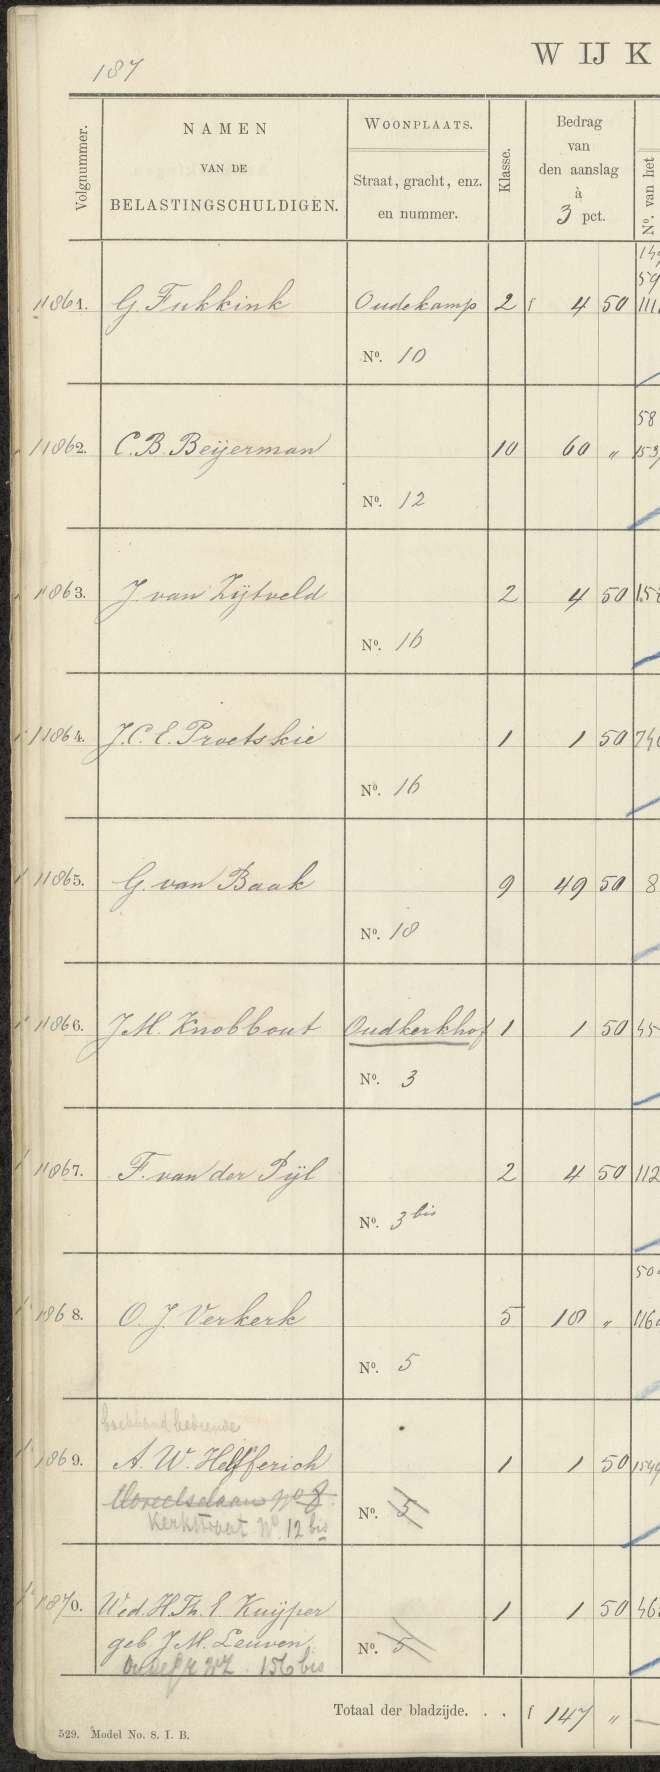

In [53]:
# Display the target image
print("Target image for few-shot experiment:\n")
display_image(target_image_fewshot)

In [54]:
# Parse the response
if response_fewshot.text:
    prediction_fewshot = json.loads(response_fewshot.text)
    
    print("Model Output (Few-Shot):")
    print("=" * 80)
    print(json.dumps(prediction_fewshot[:3], indent=2, ensure_ascii=False))
    print(f"\n... ({len(prediction_fewshot)} total records)")
else:
    print("⚠ No response text received")
    prediction_fewshot = None

Model Output (Few-Shot):
[
  {
    "volgnummer": 1861,
    "title": null,
    "initials": "G.",
    "surname": "Turkink",
    "maiden_name": null,
    "street": "Oudekamp",
    "house_number": "10",
    "class": 2,
    "tax": 4.5
  },
  {
    "volgnummer": 1862,
    "title": null,
    "initials": "C.B.",
    "surname": "Beijerman",
    "maiden_name": null,
    "street": "Oudekamp",
    "house_number": "12",
    "class": 10,
    "tax": 60.0
  },
  {
    "volgnummer": 1863,
    "title": null,
    "initials": "J.",
    "surname": "van Nijveld",
    "maiden_name": null,
    "street": "Oudekamp",
    "house_number": "16",
    "class": 2,
    "tax": 4.5
  }
]

... (10 total records)


In [55]:
# Load ground truth for comparison
gt_fewshot = load_ground_truth(target_image_fewshot)

print("Ground Truth:")
print("=" * 80)
print(json.dumps(gt_fewshot[:3], indent=2, ensure_ascii=False))
print(f"\n... ({len(gt_fewshot)} total records)")

Ground Truth:
[
  {
    "volgnummer": 1861,
    "title": null,
    "initials": "G.",
    "surname": "Fukkink",
    "maiden_name": null,
    "street": "Oudekamp",
    "house_number": "10",
    "class": 2,
    "tax": 4.5
  },
  {
    "volgnummer": 1862,
    "title": null,
    "initials": "C.B.",
    "surname": "Beijerman",
    "maiden_name": null,
    "street": "Oudekamp",
    "house_number": "12",
    "class": 10,
    "tax": 60.0
  },
  {
    "volgnummer": 1863,
    "title": null,
    "initials": "J.",
    "surname": "van Zijtveld",
    "maiden_name": null,
    "street": "Oudekamp",
    "house_number": "16",
    "class": 2,
    "tax": 4.5
  }
]

... (10 total records)


In [56]:
# Compare results
if prediction_fewshot:
    compare_results(prediction_fewshot, gt_fewshot, target_image_fewshot)


Comparison for NL-UtHUA_A376076_000033_l.jpg
Field-level accuracy: 82/90 (91.1%)
Records compared: 10/10

First record with errors (record #1):
  • surname:
      Predicted:    Turkink
      Ground truth: Fukkink


In [57]:
# Display token usage and cost
response_fewshot.usage_metadata


GenerateContentResponseUsageMetadata(
  candidates_token_count=970,
  prompt_token_count=6295,
  prompt_tokens_details=[
    ModalityTokenCount(
      modality=<MediaModality.TEXT: 'TEXT'>,
      token_count=5263
    ),
    ModalityTokenCount(
      modality=<MediaModality.IMAGE: 'IMAGE'>,
      token_count=1032
    ),
  ],
  total_token_count=7265
)

## 7. Comparison & Discussion

Let's compare the zero-shot and few-shot approaches side-by-side.

In [58]:
# Side-by-side comparison
print("ZERO-SHOT vs FEW-SHOT COMPARISON")
print("=" * 80)

if prediction_zeroshot and prediction_fewshot:
    # Calculate metrics for both
    def calculate_accuracy(pred, gt):
        if not pred or not isinstance(pred, list):
            return 0, 0
        total = 0
        correct = 0
        for p, g in zip(pred, gt):
            for field in ['volgnummer', 'title', 'initials', 'surname', 'maiden_name',
                          'street', 'house_number', 'class', 'tax']:
                total += 1
                if p.get(field) == g.get(field):
                    correct += 1
        return correct, total
    
    zs_correct, zs_total = calculate_accuracy(prediction_zeroshot, gt_zeroshot)
    fs_correct, fs_total = calculate_accuracy(prediction_fewshot, gt_fewshot)
    
    zs_acc = (zs_correct / zs_total * 100) if zs_total > 0 else 0
    fs_acc = (fs_correct / fs_total * 100) if fs_total > 0 else 0
    
    print(f"\n{'Metric':<25} {'Zero-Shot':<20} {'Few-Shot':<20}")
    print("-" * 80)
    print(f"{'Field accuracy':<25} {zs_correct}/{zs_total} ({zs_acc:.1f}%){'':<8} {fs_correct}/{fs_total} ({fs_acc:.1f}%)")
    print(f"{'Input tokens':<25} {response_zeroshot.usage_metadata.prompt_token_count:,}{'':<14} {response_fewshot.usage_metadata.prompt_token_count:,}")
    print(f"{'Total tokens':<25} {response_zeroshot.usage_metadata.total_token_count:,}{'':<14} {response_fewshot.usage_metadata.total_token_count:,}")
    
    improvement = fs_acc - zs_acc
    token_increase = ((response_fewshot.usage_metadata.total_token_count / 
                      response_zeroshot.usage_metadata.total_token_count - 1) * 100)
    
    print("\n" + "=" * 80)
    print(f"Few-shot accuracy change: {improvement:+.1f} percentage points")
    print(f"Token usage increase: {token_increase:.1f}%")
else:
    print("Cannot compare - one or both predictions missing")

ZERO-SHOT vs FEW-SHOT COMPARISON

Metric                    Zero-Shot            Few-Shot            
--------------------------------------------------------------------------------
Field accuracy            78/90 (86.7%)         82/90 (91.1%)
Input tokens              837               6,295
Total tokens              1,812               7,265

Few-shot accuracy change: +4.4 percentage points
Token usage increase: 300.9%


## 9. Next Steps & Resources

For detailed evaluation results, including:

- Character-level error rates across all models
- Cost-performance analysis
- Statistical evaluation (done in R)
- Discussion of implications for historical research

See: `report/report.md` in the repository

**💻 Code Repository**

GitHub: https://github.com/HIP-NL/nocr-experiments

The repository includes:
- Full experiment script (`experiments/run_experiments.py`)
- All 4 sample images and ground truth
- R evaluation scripts
- Complete results from all experiments

**📊 Evaluation**

The full evaluation pipeline uses R to calculate:
- Character Error Rate (CER) using edit distance
- Cell Error Rate across all fields
- Statistical comparisons between configurations

These scripts are available in the repository but not included in this demo notebook.